# KNN Classification Demo

In this demo, I will perform a Heart Disease classification analysis on a dataset available here: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download. First, basic EDA and preprocesing will be done, then I will perform cross-validated K-nearest neighbor classification using Gower distance. For exercise, I will not use any packaged functions for KNN or cross validation.

First I will import the required packages and read in the dataframe. Following, I will check the data types & missing values, assigning proper data types and handling NAs if present.

In [1]:
import pandas as pd
import numpy as np
import gower
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

hd_df = pd.read_csv("heart 2.csv")
hd_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
hd_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [3]:
hd_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

I will cast HeartDisease, and FastingBS from integer to object because of their binary nature. No null handling needs to be done here.

In [4]:
hd_df['FastingBS'] = hd_df['FastingBS'].astype(str)
hd_df['HeartDisease'] = hd_df['HeartDisease'].astype(str)

Next, I will check the distribution of the outcome variable. This is essential knowledge in predictive modelling.

In [5]:
hd_df['HeartDisease'].value_counts(normalize = True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

Since KNN utilizes a distance metric between records, continuous predictors should be scaled before application. I will check the distribution of the continuous predictors in order to determine the best method of scaling.

In [6]:
continuous_df = hd_df.select_dtypes(exclude = 'object')

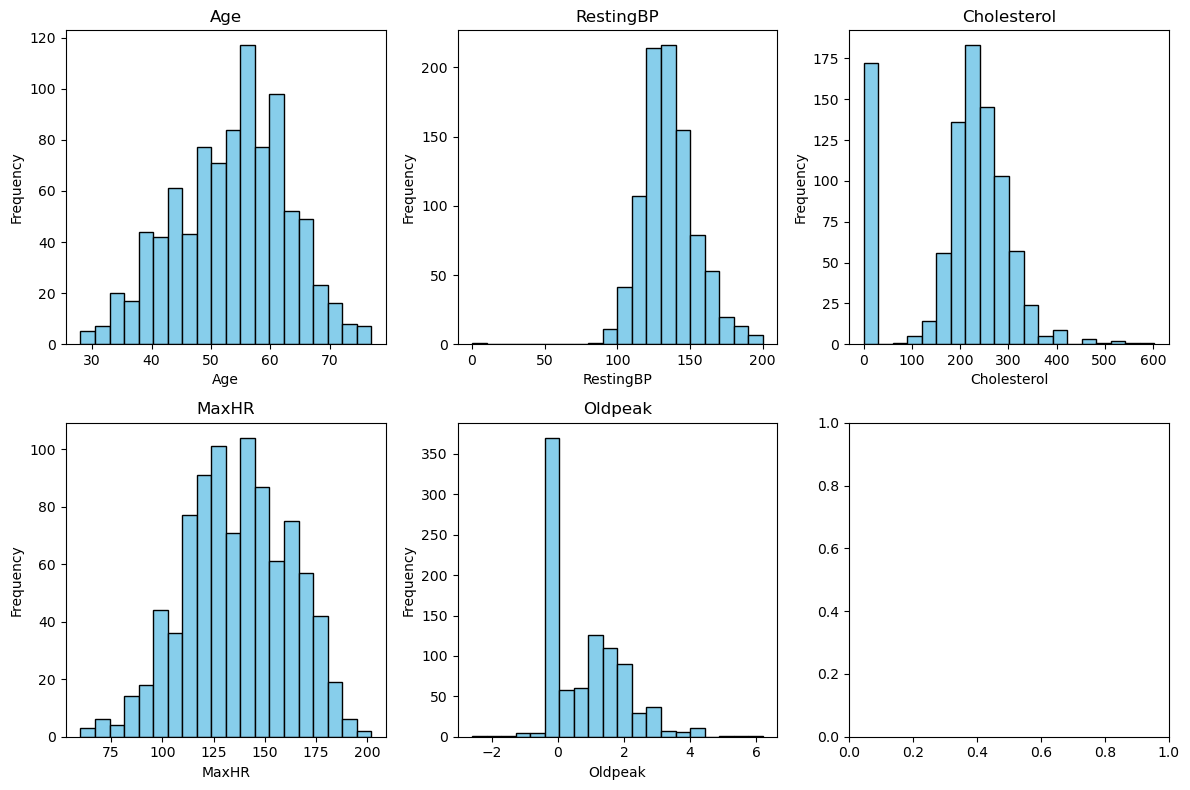

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8)) ## create a 2x3 grid for frequency histograms
axes = axes.flatten() ## flatten axes array to make it easier to iterate over
## iterate over attributes and plot histograms
for i, attribute in enumerate(continuous_df.columns):
    ax = axes[i] ## select current plot cell
    # plot histogram for selected cell
    continuous_df[attribute].plot(kind='hist', bins = 20, ax=ax, title=attribute, color='skyblue', edgecolor='black')
    # set plot cell labels
    ax.set_xlabel(attribute)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
len(hd_df[hd_df.Oldpeak == 0]) / len(hd_df)

0.4008714596949891

In [9]:
len(hd_df[hd_df.Cholesterol == 0]) / len(hd_df)

0.18736383442265794

In [10]:
len(hd_df[hd_df.RestingBP == 0]) / len(hd_df)

0.0010893246187363835

It appears there was null filling with zero in this dataset, as 18.7% of the observations in the dataset have serum cholesterol values of 0 mm/dl, which isn't physiologically possible (and .1% with a resting blood pressure of 0 mm Hg). 40% of the observations have values of zero for oldpeak, but based on my research, 0 is a normal value of oldpeak, thus I cannot tell if there was null filling done here.

I am going to drop rows with values of zero for Cholesterol or RestingBP because it is clear that these values were improperly filled with zero, and I won't apply any removal/changes to zero values for Oldpeak because of the ambiguity of potential null filling. This is a large portion of data to drop (~19%), but the bias induced by zero filling must be addressed here. Advanced imputation could also be attempted here to avoid data loss, but for the purpose of the analysis I will move forward with dropping observations.

In [11]:
hd_df_prepped = hd_df[(hd_df.Cholesterol != 0) & (hd_df.RestingBP != 0)].copy()

In [12]:
len(hd_df_prepped) / len(hd_df)

0.8126361655773421

We retain 81.3% of the original dataset. Next, I will scale the continuous predictors. Since they appear to be approximately normally distributed (with the exception of zeroes in Oldpeak), I will use Z-score normalization, or scikit-learn's StandardScaler.

In [13]:
continuous_data = hd_df_prepped.select_dtypes(exclude='object').copy()
scaled_data = StandardScaler().fit_transform(continuous_data) ## scale continuous cols
hd_df_prepped[continuous_data.columns] = scaled_data ## replace cols with their scaled values

Next, we will move into classification. I will use cross validation to estimate error in the KNN application, but first, I will demonstrate gower distancing on the first CV fold. Gower distance is a metric which can be applied on cases of mixed data types, applying different calculations for categorical, ordinal, and continuous features and aggregating these calculations to get single distances between records. Gower distance can range between 0 & 1.

In [14]:
hd_df_prepped = hd_df_prepped.sample(frac = 1,  random_state = 33) ## shuffle df
hd_df_prepped_splits = np.array_split(hd_df_prepped, 10) ## split df into 10 equal sized partitions
X_test = hd_df_prepped_splits[0].drop('HeartDisease', axis=1)
X_train = pd.concat(hd_df_prepped_splits[1:9]).drop('HeartDisease', axis=1)
y_test = hd_df_prepped_splits[0]['HeartDisease']
y_train = pd.concat(hd_df_prepped_splits[1:9])['HeartDisease']
gower_mat = pd.DataFrame(gower.gower_matrix(X_train, X_test, cat_features = [False, True, True, False, False, True, True, False, True, False, True]))

In [15]:
len([x for x in y_train.tolist() if x == '1']) / len(y_train)

0.48408710217755446

In [16]:
gower_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.135883,0.152581,0.130015,0.131913,0.466489,0.399922,0.352853,0.348517,0.328437,0.278849,...,0.469101,0.155951,0.335453,0.508461,0.431200,0.347484,0.407083,0.312511,0.179165,0.262836
1,0.291783,0.327268,0.224896,0.135885,0.317074,0.318711,0.251340,0.202962,0.270466,0.350342,...,0.447228,0.129848,0.154872,0.363959,0.461146,0.271779,0.239508,0.167733,0.284927,0.313971
2,0.223393,0.398121,0.258490,0.347586,0.515833,0.152184,0.280371,0.401721,0.287407,0.255868,...,0.555077,0.345260,0.367879,0.562718,0.659904,0.292087,0.444038,0.355360,0.307640,0.310069
3,0.411431,0.288768,0.327232,0.253063,0.183922,0.266541,0.353605,0.078468,0.143086,0.449133,...,0.528703,0.247612,0.032099,0.230807,0.342423,0.153057,0.336932,0.067564,0.376883,0.463959
4,0.430365,0.582908,0.520640,0.446470,0.467022,0.393437,0.482876,0.394401,0.457501,0.363955,...,0.425647,0.397624,0.424160,0.461752,0.479145,0.518291,0.300783,0.393649,0.524988,0.541331


In the matrix above, the columns correspond to the individual training cases, and rows correspond to the test cases, with each cell being the gower distance between the two records.

Now I will next perform K-Nearest Neighbor classification using 10-fold cross validation. Cross validation is essential in optimizing machine learning analyses because cross validation ensures that the entire dataset will be utilized in training the model, resulting in more robust error estimation.

Within each CV fold, the k nearest training cases for each test case (k lowest distances for each column) will be identified, and then the mode of the class labels of the k nearest neighbors will be calculated to assign a class label to the test case. In the case of tie in the mode, I will use the distribution of the outcome in the training data to randomly assign the classification (ie. if 60% of training data has positive outcome, I will randomly sample with 60% chance positive). Within each CV fold, I will iterate over values of k from 1 to 20, and calculate the prediction error of each k. The overall result will be a 20x10 dataframe of K values and CV fold errors.

In [17]:
## function to calculate modes, and return random sample of 0/1 with train outcome prop in the case of a tie
def find_mode(data, train_pos_outcome_prop):
    counts = Counter(data)
    max_count = max(counts.values())
    modes = [key for key, value in counts.items() if value == max_count]
    tie_class = np.random.choice(['0','1'], size=1, p=[1 - train_pos_outcome_prop, train_pos_outcome_prop])
    return tie_class if len(modes) > 1 else modes[0]

error_dfs = [] ## empty list to store k error dfs each fold
for i in range(0,10): ## i is the test index of the 10 folds of df
    train_inds = list(set(range(0,10)) - set([i])) ## set train indices
    X_test = hd_df_prepped_splits[i].drop('HeartDisease', axis=1)
    X_train = pd.concat([hd_df_prepped_splits[ind] for ind in train_inds]).drop('HeartDisease', axis=1)
    y_test = hd_df_prepped_splits[i]['HeartDisease']
    y_test = y_test.reset_index()
    y_train = pd.concat([hd_df_prepped_splits[ind] for ind in train_inds])['HeartDisease']
    y_train_pos_outcome_prop = len([x for x in y_train.tolist() if x == '1']) / len(y_train) ## prop for mode ties
    gower_mat = pd.DataFrame(gower.gower_matrix(X_train, X_test, cat_features = [False, True, True, False, False, True, True, False, True, False, True]))
    k_errors = [] ## empty list to store errors for each k for current CV fold
    for k in range(1, 21):
        nearest_neighbors = {} ## empty dict to store k nearest neighbor indices for each test index
        nearest_neighbors_labels = {} ## empty dict to store k nearest neighbor class labels for each test index
        classifications = {} ## empty dict to store classifications based on k nearest neighbors
        # Iterate through each test case and classify based on k lowest distances (k nearest training neighbors)
        for column in gower_mat.columns:
            nearest_neighbors[column] = gower_mat[column].nsmallest(k).index.tolist() ## get indexes of k nearest training obs
            nearest_neighbors_labels[column] = y_train.iloc[nearest_neighbors[column]].values.tolist() ## get y labels of nearest neighbors
            mode = find_mode(nearest_neighbors_labels[column], y_train_pos_outcome_prop) ## get the mode of the nn labels using premade function
            classifications[column] = mode
        ## get accuracy of test classifications for k
        correct_predictions = 0
        total_predictions = len(y_test)
        for index, row in y_test.iterrows():
            true_class = row['HeartDisease']
            predicted_class = classifications.get(index)  # get the predicted class from the dictionary
            if predicted_class is not None and predicted_class == true_class:
                correct_predictions += 1
        error = 1 - (correct_predictions / total_predictions)
        k_errors.append(error)
    ks = list(range(1,21))
    errors = pd.DataFrame({'K':ks, 'Error_testsplit_' + str(i):k_errors}) ## create df of k & errors for current CV fold
    error_dfs.append(errors)
k_split_errors = reduce(lambda left,right: pd.merge(left,right,on='K',), error_dfs)
k_split_errors.head()

,K,Error_testsplit_0,Error_testsplit_1,Error_testsplit_2,Error_testsplit_3,Error_testsplit_4,Error_testsplit_5,Error_testsplit_6,Error_testsplit_7,Error_testsplit_8,Error_testsplit_9
0,1,0.160000,0.173333,0.200000,0.133333,0.186667,0.213333,0.162162,0.189189,0.229730,0.148649
1,2,0.146667,0.186667,0.226667,0.146667,0.120000,0.240000,0.175676,0.148649,0.229730,0.148649
2,3,0.160000,0.146667,0.173333,0.093333,0.146667,0.186667,0.135135,0.108108,0.229730,0.108108
3,4,0.093333,0.146667,0.160000,0.106667,0.146667,0.200000,0.148649,0.135135,0.202703,0.108108
4,5,0.133333,0.133333,0.186667,0.093333,0.146667,0.160000,0.148649,0.135135,0.202703,0.121622


Now I will average the CV fold errors for each k to get overall CV errors.

In [20]:
avg_errors = k_split_errors.drop('K', axis = 1).mean(axis=1)
k_avg_errors = pd.concat([k_split_errors['K'], avg_errors], axis = 1)
k_avg_errors.rename(columns = {0:'cv_error'}, inplace = True)
k_avg_errors.head()

,K,cv_error
0,1,0.179640
1,2,0.176937
2,3,0.148775
3,4,0.144793
4,5,0.146144


Finally, I will plot the CV errors for each k and determine the optimal k based on this analysis.

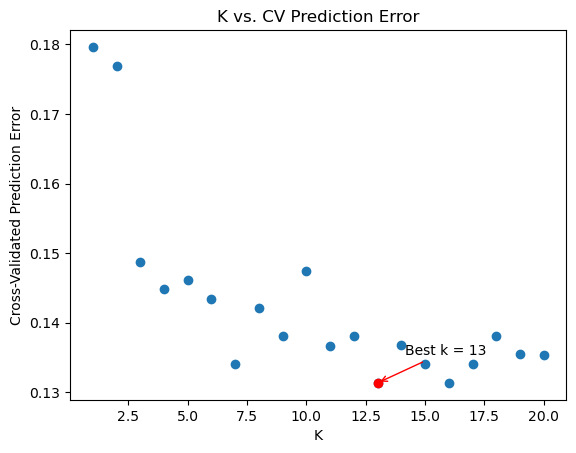

In [19]:
# Create a scatter plot for k & error
plt.scatter(k_avg_errors['K'], k_avg_errors['cv_error'])
plt.xlabel('K')
plt.ylabel('Cross-Validated Prediction Error')
plt.title('K vs. CV Prediction Error')

# Find the index of the point with the lowest error
best_k_index = k_avg_errors['cv_error'].idxmin()
best_k_value = k_avg_errors.loc[best_k_index, 'K']

# Annotate the point with the lowest error in red
plt.scatter(k_avg_errors.loc[best_k_index, 'K'], k_avg_errors.loc[best_k_index, 'cv_error'], color='red')
plt.annotate(f'Best k = {best_k_value}', xy=(k_avg_errors.loc[best_k_index, 'K'], k_avg_errors.loc[best_k_index, 'cv_error']), xytext=(20, 20),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

plt.show()

In [22]:
k_avg_errors.cv_error.min()

0.13133333333333333

We end up with K=13 as the best K here, with an estimated prediction error of 13.1%. 

Thanks for following along! This demo was designed to guide through the K-Nearest Neighbors classification process using gower distancing & cross-validation. Not using a package for machine learning techniques is a great way to strengthen understanding.